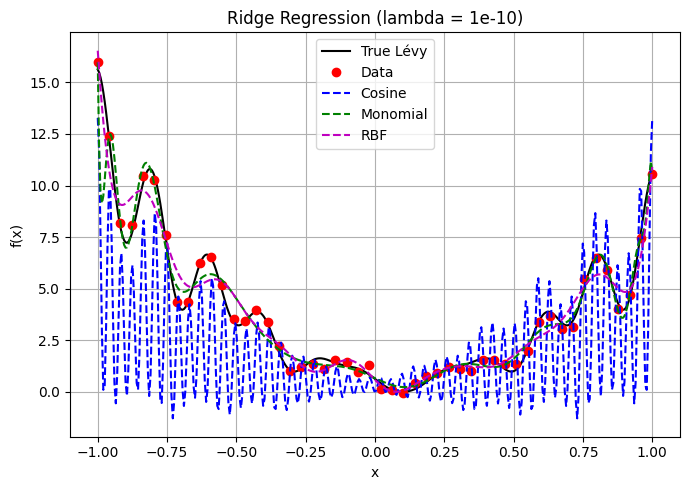

Saved figure: levy_approx_lambda_1e-10.pdf


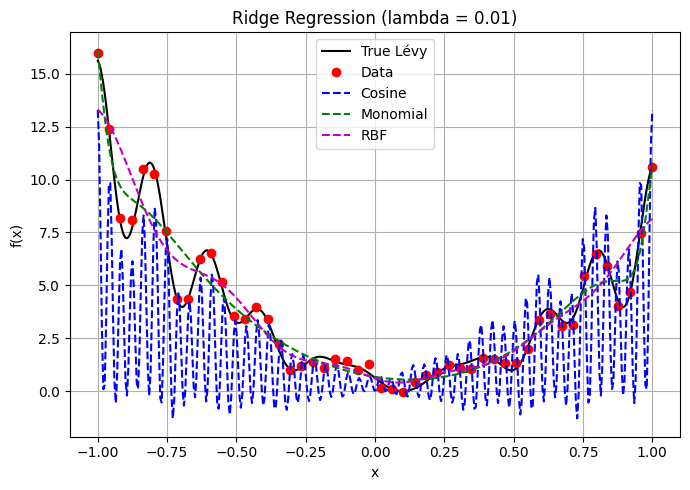

Saved figure: levy_approx_lambda_0.01.pdf


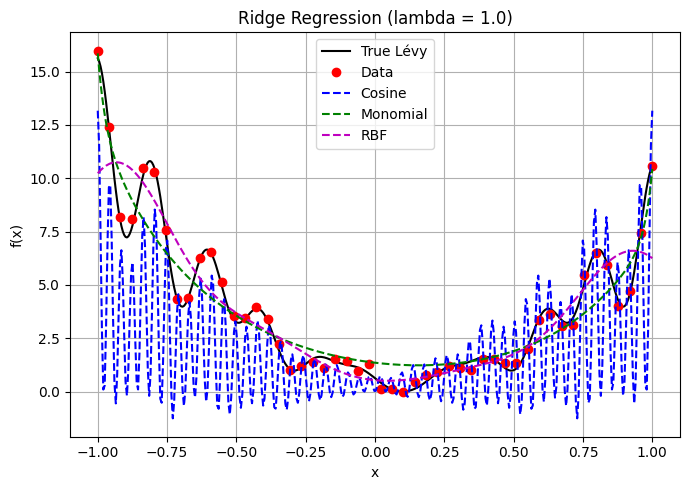

Saved figure: levy_approx_lambda_1.0.pdf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def levy_function(x):
    """
    1D Lévy function, defined for x in [-1, 1].
    """
    w = 1 + (10*x - 1)/4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2*np.pi*w)**2)

def build_cosine_matrix(x, N):
    """
    Construct a matrix Psi where Psi_{k,n} = cos(n*pi*x_k).
    x : array-like, the input points
    N : size of dictionary
    """
    Psi = np.zeros((len(x), N))
    for n in range(N):
        Psi[:, n] = np.cos(np.pi * n * x)
    return Psi

def build_monomial_matrix(x, N):
    """
    Construct a matrix Psi where Psi_{k,n} = (x_k)^n.
    x : array-like, the input points
    N : size of dictionary
    """
    Psi = np.zeros((len(x), N))
    for n in range(N):
        Psi[:, n] = x**n
    return Psi

def build_rbf_matrix(x, N, ell=0.2):
    """
    Construct an RBF design matrix with evenly spaced centers from -1 to 1.
    Psi_{k,n} = exp(-(x_k - z_n)^2 / (2*ell^2)),
    where z_n = -1 + 2n/(N-1), if N>1.
    x   : array-like, the input points
    N   : size of dictionary
    ell : length scale for Gaussians
    """
    Psi = np.zeros((len(x), N))
    if N == 1:
        # degenerate case: single center at x=0
        z = np.array([0.0])
    else:
        z = np.linspace(-1, 1, N)
    for n in range(N):
        Psi[:, n] = np.exp(-(x - z[n])**2 / (2*ell**2))
    return Psi

def ridge_regression_solve(Psi, y, lam):
    """
    Solve the ridge regression problem:
    (Psi^T Psi + lam I) c = Psi^T y.
    Psi : (K x N) design matrix
    y   : length-K observation vector
    lam : regularization parameter (float)
    """
    N = Psi.shape[1]
    A = Psi.T @ Psi + lam * np.eye(N)
    b = Psi.T @ y
    c = np.linalg.solve(A, b)
    return c

# ---------------------------
# 1) Generate synthetic data
# ---------------------------
K = 50
x_data = np.linspace(-1, 1, K)
true_y = levy_function(x_data)

# Add Gaussian noise
np.random.seed(0)
noise_sigma = 0.2
noise = np.random.normal(0, noise_sigma, K)
y_data = true_y + noise

# ---------------------------
# 2) Choose dictionary size, lambdas
# ---------------------------
N = 50  # dictionary size
lambdas = [1e-10, 1e-2, 1.0]

# Evaluation grid for plotting
x_plot = np.linspace(-1, 1, 400)
f_true = levy_function(x_plot)

# ---------------------------
# 3) Build each dictionary for the data
# ---------------------------
Psi_cos = build_cosine_matrix(x_data, N)
Psi_mon = build_monomial_matrix(x_data, N)
Psi_rbf = build_rbf_matrix(x_data, N, ell=0.2)

Psi_cos_plot = build_cosine_matrix(x_plot, N)
Psi_mon_plot = build_monomial_matrix(x_plot, N)
Psi_rbf_plot = build_rbf_matrix(x_plot, N, ell=0.2)

# ---------------------------
# 4) Plot each lambda in its own figure
# ---------------------------
for lam in lambdas:
    # Ridge regression for each dictionary
    c_cos = ridge_regression_solve(Psi_cos, y_data, lam)
    c_mon = ridge_regression_solve(Psi_mon, y_data, lam)
    c_rbf = ridge_regression_solve(Psi_rbf, y_data, lam)

    # Evaluate each approximation on x_plot
    f_cos = Psi_cos_plot @ c_cos
    f_mon = Psi_mon_plot @ c_mon
    f_rbf = Psi_rbf_plot @ c_rbf

    # Create a new figure for this lambda
    plt.figure(figsize=(7, 5))
    plt.plot(x_plot, f_true, 'k', label="True Lévy")
    plt.plot(x_data, y_data, 'ro', label="Data")
    plt.plot(x_plot, f_cos, 'b--', label="Cosine")
    plt.plot(x_plot, f_mon, 'g--', label="Monomial")
    plt.plot(x_plot, f_rbf, 'm--', label="RBF")
    plt.title(f"Ridge Regression (lambda = {lam})")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()

    # Save the figure with a name reflecting this lambda
    plt.tight_layout()
    filename = f"levy_approx_lambda_{lam}.pdf"
    plt.savefig(filename)
    plt.show()
    print(f"Saved figure: {filename}")